In [1]:
import numpy as np         # para fazer contas e mexer com matrizes
import pandas as pd        # para montar DataFrames (tabelas de bancos de dados)

from pathlib import Path   # para trabalhar com diretorios e arquivos
import pickle              # para gravar e ler dados

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#import class_pig  
#import glob
#import seaborn as sns
#
#plt.style.use('ggplot')

#import os
#from scipy.optimize import curve_fit
#"""
#CUIDADO!!
#"""
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# função usada para fitar o modelo PV sigmoide (doente)
#                b                                   b
# V(x) = a + ----------------------   = a + ------------------------
#            1 + exp(-(x/d) + (c/d)          1 + exp(-x/d).exp(c/d)
#
# lim (x-> inf)  V(x) = a + b
def sigmoidvenegas1(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

def sigmoidpaiva(x,TLC,k1,k2):
    return TLC/(1+(k1*np.exp(-k2*x)))

def sigmoidpaivaoffset(x,TLC,k1,k2,offset):
    return TLC/(1+(k1*np.exp(-k2*x))) + offset

def sigmoidvenegas2(x,TLC,B,k,c,d):
    return (TLC-(B*np.exp(-k*x)))/(1 + np.exp(-(x-c)/d))

def expsalazar(x,Vo,K):
    return Vo*(1-np.exp(-K*x))



# Lendo dados

In [3]:
# verifica quais dados estão disponíveis para análise
for file_name in Path('porquinhos').rglob('*.pickle'):
    print(file_name.name)

porquinho_mra34.pickle
porquinho_mra28.pickle
porquinho_mra31.pickle
porquinho_mra32.pickle
porquinho_mra26.pickle
porquinho_mra29.pickle
porquinho_mra33.pickle


In [4]:
"""
lista de dataframe: Cada elemento da lista corresponde a um dataframe de um porco/manobra/dados PV
"""
dataframes_lst = []

for file_name in Path('porquinhos').rglob('*.pickle'):
    
    print(f"\rLendo {file_name.name}\t\t\t")

    with open(file_name, "rb") as file: # abre o arquivo.pickle

        porquinho = pickle.load(file)
        for manobra in porquinho: #Para cada manobra 

            if manobra == "D": # Posso fazer 3,4,5 passos
                n_steps = 5
            elif manobra == "C": # Posso fazer 3,4 passos
                n_steps = 4
            elif manobra == "B": # Posso fazer 3 passos
                n_steps = 3

            # Formato os dados de entrada
            format_data = []

            for pi, pe, wi, we in zip(porquinho[manobra]["p_i"], porquinho[manobra]["p_e"],
                                      porquinho[manobra]["w_i"], porquinho[manobra]["w_e"]):

                format_data.extend([pi,wi,pe,we])

            format_data = np.array(format_data).reshape(-1,2) # monta matriz de N linhas e 2 colunas
            

            ##########################################################
            caso = []
            caso.append(porquinho.name)
            caso.append(manobra)
            caso.append(format_data)
            caso.append(n_steps)
            casodf = pd.DataFrame(caso, index = ['Animal', 'Manobra', 'Dados', 'n_steps']).T
            dataframes_lst.append(casodf)


Lendo porquinho_mra34.pickle			
Lendo porquinho_mra28.pickle			
Lendo porquinho_mra31.pickle			
Lendo porquinho_mra32.pickle			
Lendo porquinho_mra26.pickle			
Lendo porquinho_mra29.pickle			
Lendo porquinho_mra33.pickle			


In [5]:
dadosdf = pd.concat(dataframes_lst, ignore_index=True)

In [6]:
dadosdf.head(4)

,Animal,Manobra,Dados,n_steps
0,mra34,C,"[[9.928905963897705, -259.58831787109375], [20...",4
1,mra34,D,"[[9.9609375, -167.6243133544922], [20.25208377...",5
2,mra34,B,"[[10.135156631469727, -149.72845458984375], [2...",3
3,mra28,C,"[[10.287500381469727, -152.2864532470703], [20...",4


In [7]:
caso_teste = 15
dadosdf.iloc[caso_teste]

Animal                                                 mra29
Manobra                                                    D
Dados      [[10.286250114440918, -210.43722534179688], [2...
n_steps                                                    5
Name: 15, dtype: object

In [8]:
dadosdf.iloc[caso_teste].Dados

array([[  10.28625011, -210.43722534],
       [  20.3008337 ,  -78.49641418],
       [  15.0941205 , -118.89096069],
       [  25.34416771,  -14.55855656],
       [  19.99500084,   33.22951126],
       [  30.33500004,  147.49980164],
       [  25.00092602,  313.02911377],
       [  35.41666794,  434.08279419],
       [  30.0879631 ,  538.45410156],
       [  40.43532372,  647.34619141]])

In [9]:
def Data2PV(data):
    data2 = data[0::2, :]
    pressures = data2[:,0]
    volumes = data2[:,1]
    return pressures,volumes

In [10]:
pv_lst = []
for idx,caso in dadosdf.iterrows():
    pv = []
    #print(f'{caso.Animal} {caso.Manobra}')
    ps,vs = Data2PV(caso.Dados)
    #pv.append(idx)
    pv.append(ps)
    pv.append(vs)
    pvdf = pd.DataFrame([pv], columns = ['Pressoes', 'Volumes'])
    pv_lst.append(pvdf)
    #parameters, pcov = curve_fit(func, 
    #                                                     self.interp_pressures,  
    #                                                     self.interp_volumes, 
    #                                                     method=estimator,
    #                                                     bounds=meus_bounds)


In [11]:
pvdf_all = pd.concat(pv_lst, ignore_index=True)
pvdf_all.head(5)

,Pressoes,Volumes
0,"[9.928905963897705, 14.968489646911621, 20.058...","[-259.58831787109375, -81.21270751953125, 147...."
1,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19..."
2,"[10.135156631469727, 15.052343845367432, 20.00...","[-149.72845458984375, 36.645347595214844, 243...."
3,"[10.287500381469727, 14.931250095367432, 20.21...","[-152.2864532470703, -45.45492172241211, 234.1..."
4,"[10.021874904632568, 14.962499618530273, 20.01...","[-128.87612915039062, -2.0903725624084473, 208..."


In [12]:
dadosdf2 = pd.concat((dadosdf,pvdf_all),axis=1)


In [13]:
dadosdf2

,Animal,Manobra,Dados,n_steps,Pressoes,Volumes
0,mra34,C,"[[9.928905963897705, -259.58831787109375], [20...",4,"[9.928905963897705, 14.968489646911621, 20.058...","[-259.58831787109375, -81.21270751953125, 147...."
1,mra34,D,"[[9.9609375, -167.6243133544922], [20.25208377...",5,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19..."
2,mra34,B,"[[10.135156631469727, -149.72845458984375], [2...",3,"[10.135156631469727, 15.052343845367432, 20.00...","[-149.72845458984375, 36.645347595214844, 243...."
3,mra28,C,"[[10.287500381469727, -152.2864532470703], [20...",4,"[10.287500381469727, 14.931250095367432, 20.21...","[-152.2864532470703, -45.45492172241211, 234.1..."
4,mra28,B,"[[10.021874904632568, -128.87612915039062], [2...",3,"[10.021874904632568, 14.962499618530273, 20.01...","[-128.87612915039062, -2.0903725624084473, 208..."
5,mra28,D,"[[10.240625381469727, -179.3195037841797], [20...",5,"[10.240625381469727, 14.828125, 20.05937480926...","[-179.3195037841797, -62.187042236328125, 182...."
6,mra31,D,"[[10.0, -107.7169418334961], [20.2000007629394...",5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19..."
7,mra31,B,"[[10.300000190734863, -25.01786231994629], [20...",3,"[10.300000190734863, 15.100000381469727, 19.89...","[-25.01786231994629, 122.25248718261719, 244.6..."
8,mra31,C,"[[9.699999809265137, -228.3211212158203], [20....",4,"[9.699999809265137, 15.300000190734863, 20.100...","[-228.3211212158203, -71.18547058105469, 125.5..."
9,mra32,D,"[[10.625260829925537, -53.54884338378906], [20...",5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5..."


[ 86.29057838 180.70531397  91.8599463   -2.22388969]
mra34


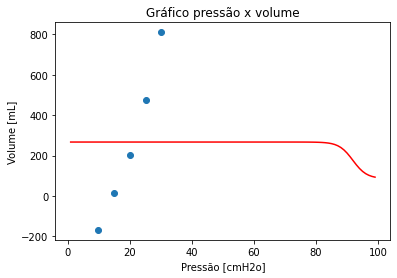

[-297.05994728 1381.37407352   23.66987599    5.63017173]
mra28


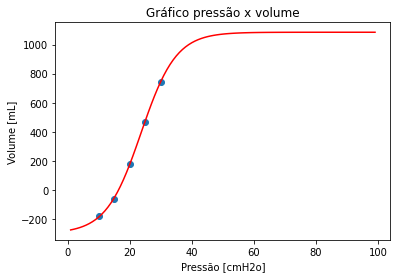

[-3.01799654e+01  4.45996027e+02  1.91625516e+01  2.43327789e-02]
mra31


<ipython-input-2-d1be3fbc6e7a>:8: RuntimeWarning: overflow encountered in exp
  return a + b/(1 + np.exp(-(x-c)/d))


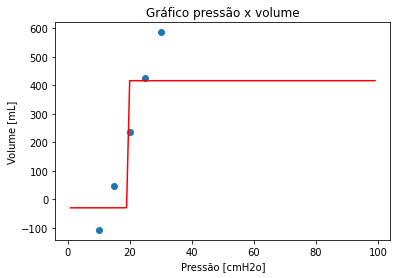

[-139.55927445  634.25669483   20.5539271     5.33333484]
mra32


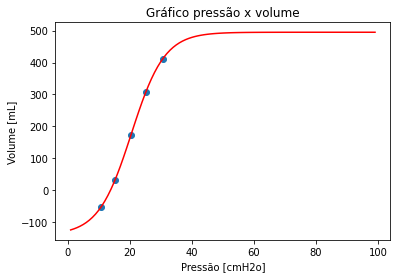

[-294.6755145  1695.33852648   28.10570416    6.39623691]
mra26


<ipython-input-2-d1be3fbc6e7a>:8: RuntimeWarning: overflow encountered in exp
  return a + b/(1 + np.exp(-(x-c)/d))


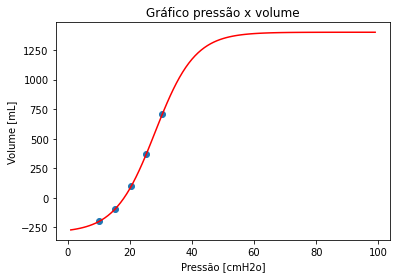

<ipython-input-2-d1be3fbc6e7a>:8: RuntimeWarning: overflow encountered in exp
  return a + b/(1 + np.exp(-(x-c)/d))


[-9.87120203e+01  5.24466090e+02  2.09027000e+01  1.06436931e-02]
mra29


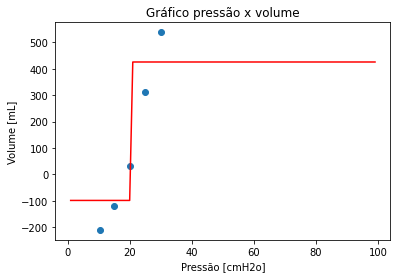

[-500.91274163 4760.42128702   37.81277779   11.85675852]
mra33


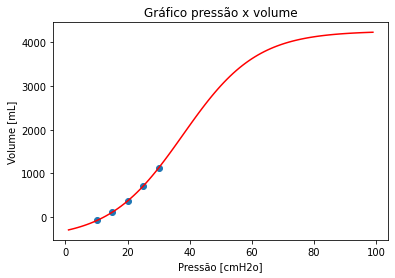

In [14]:
for i in range(21):
    caso_teste=i
    metodo = 'trf' # lm, dogbox, trf
    modelo = sigmoidvenegas1
    if dadosdf2.iloc[caso_teste].n_steps ==5:
        p = dadosdf2.iloc[caso_teste].Pressoes
        v = dadosdf2.iloc[caso_teste].Volumes
        parameters, pcov = curve_fit(modelo, p, v, method=metodo)
        print(parameters)
        print(dadosdf2.iloc[caso_teste].Animal)
        meu_p = range(1,100)
        meu_v = modelo(meu_p,*parameters)
        plt.scatter(dadosdf2.iloc[caso_teste].Pressoes,v)
        plt.plot(meu_p,meu_v,'r')
        plt.title('Gráfico pressão x volume')
        plt.xlabel('Pressão [cmH2o]')
        plt.ylabel('Volume [mL]')
        plt.show()
        plt.close()


In [43]:
# metodos : lm, dogbox, trf
def testa_modelo(df, modelo, meu_p0 = [], metodo = 'lm', n_colunas = 4, texto = '', TLC_index = 0):
    numero_de_casos = len(df)
    fig = plt.figure(figsize=(25,5*numero_de_casos/n_colunas))
    
    for caso_teste in range(numero_de_casos):
        print(f'Testando caso {caso_teste}.')
        
        #modelo = sigmoidvenegas1
        if df.iloc[caso_teste].n_steps ==5:
            p = df.iloc[caso_teste].Pressoes
            v = df.iloc[caso_teste].Volumes
            
            try:
                if (meu_p0 == []):
                    parameters, pcov = curve_fit(modelo, p, v, method=metodo)
                else:
                    parameters, pcov = curve_fit(modelo, p, v, method=metodo, p0 = meu_p0)
                print(parameters)
                print(df.iloc[caso_teste].Animal)
                meu_p = range(1,100)
                meu_v = modelo(meu_p,*parameters)
                plt.subplot(int(numero_de_casos/n_colunas)+1,n_colunas,caso_teste+1)
                fig.tight_layout()
                plt.scatter(df.iloc[caso_teste].Pressoes,v,label='Dados')
                plt.plot(meu_p,meu_v,'r',label='Ajuste')
                plt.title(f'Animal: {df.iloc[caso_teste].Animal}. TLC = {parameters[TLC_index]:.0f} mL')
                plt.xlabel('Pressão [cmH2O]')
                plt.ylabel('Volume [mL]')
                #plt.text(50,min(v),f'{texto_parametros}')
                plt.legend()
                #plt.show()
                #plt.close()
            except Exception as e:
                print('\tDeu erro...')
    fig.suptitle(f'Gráfico PV. Modelo: {modelo.__name__}. {texto}', fontsize=16, y=1.05)
    plt.show()


In [16]:
dadosdfD5 = dadosdf2[dadosdf2["n_steps"]==5]
dadosdfD5

,Animal,Manobra,Dados,n_steps,Pressoes,Volumes
1,mra34,D,"[[9.9609375, -167.6243133544922], [20.25208377...",5,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19..."
5,mra28,D,"[[10.240625381469727, -179.3195037841797], [20...",5,"[10.240625381469727, 14.828125, 20.05937480926...","[-179.3195037841797, -62.187042236328125, 182...."
6,mra31,D,"[[10.0, -107.7169418334961], [20.2000007629394...",5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19..."
9,mra32,D,"[[10.625260829925537, -53.54884338378906], [20...",5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5..."
13,mra26,D,"[[10.178125381469727, -197.8517303466797], [20...",5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13..."
15,mra29,D,"[[10.286250114440918, -210.43722534179688], [2...",5,"[10.286250114440918, 15.094120502471924, 19.99...","[-210.43722534179688, -118.89096069335938, 33...."
18,mra33,D,"[[10.312239646911621, -75.62246704101562], [20...",5,"[10.312239646911621, 14.991406440734863, 20.00...","[-75.62246704101562, 107.81485748291016, 363.4..."


# Teste dos modelos

Volumes esperados:

* MRA26: 2622 mL
* MRA29: 2151 mL

### Sigmoid Venegas sem chute inicial

Testando caso 0.
[ 86.29057838 180.70531397  91.8599463   -2.22388969]
mra34
Testando caso 1.
[-297.05994728 1381.37407352   23.66987599    5.63017173]
mra28
Testando caso 2.
[-3.01799654e+01  4.45996027e+02  1.91625516e+01  2.43327789e-02]
mra31
Testando caso 3.
[-139.55927445  634.25669483   20.5539271     5.33333484]
mra32
Testando caso 4.


<ipython-input-2-d1be3fbc6e7a>:8: RuntimeWarning: overflow encountered in exp
  return a + b/(1 + np.exp(-(x-c)/d))
<ipython-input-2-d1be3fbc6e7a>:8: RuntimeWarning: overflow encountered in exp
  return a + b/(1 + np.exp(-(x-c)/d))
<ipython-input-2-d1be3fbc6e7a>:8: RuntimeWarning: overflow encountered in exp
  return a + b/(1 + np.exp(-(x-c)/d))


[-294.6755145  1695.33852648   28.10570416    6.39623691]
mra26
Testando caso 5.
[-9.87120203e+01  5.24466090e+02  2.09027000e+01  1.06436931e-02]
mra29
Testando caso 6.
[-500.91274163 4760.42128702   37.81277779   11.85675852]
mra33


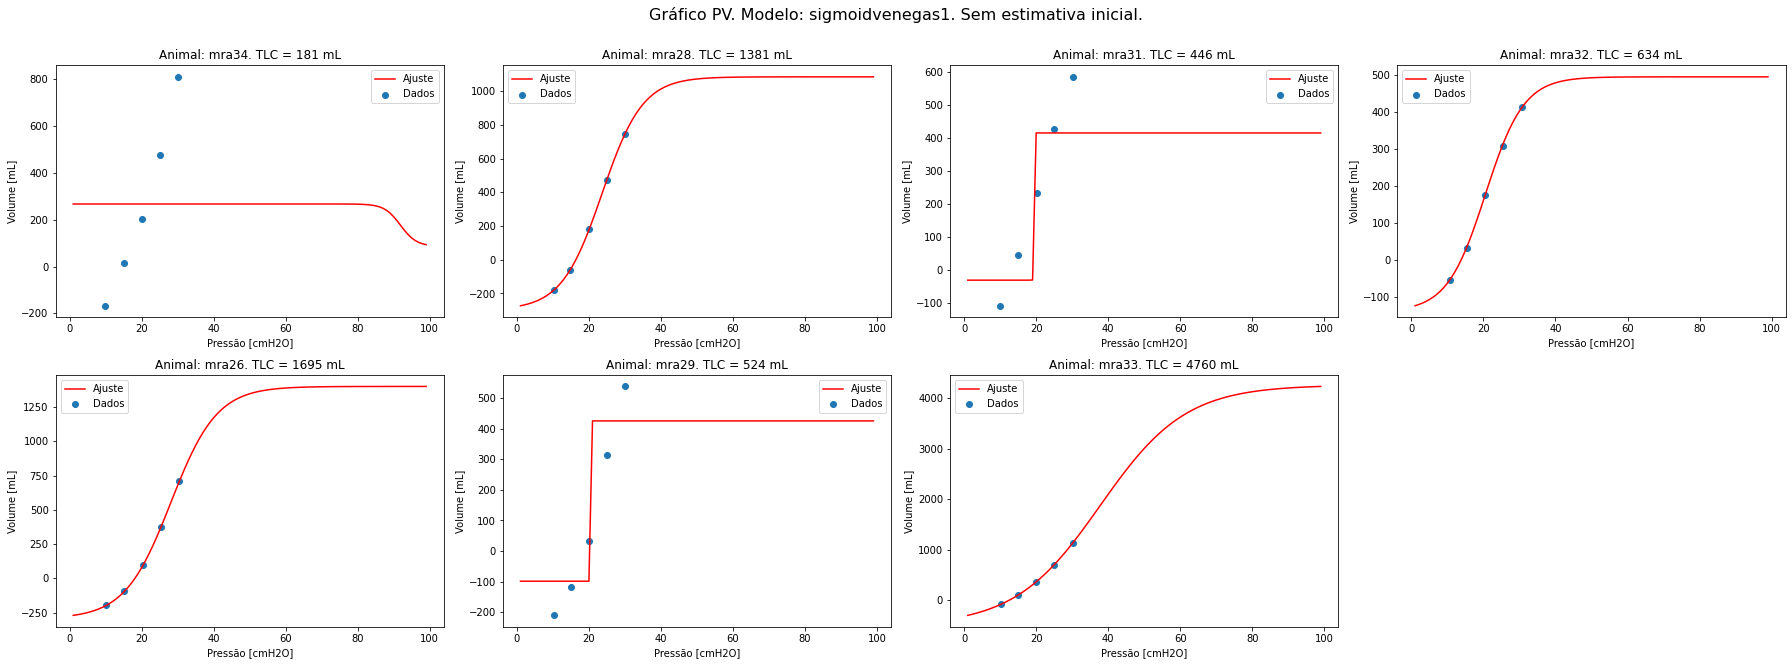

In [45]:
testa_modelo(dadosdfD5, sigmoidvenegas1, metodo = 'trf', texto = 'Sem estimativa inicial.', TLC_index=1)

### Sigmoid Venegas com chute inicial

Testando caso 0.
	Deu erro...
Testando caso 1.
[-297.05994114 1381.37405468   23.66987593    5.63017163]
mra28
Testando caso 2.
[-330.8312963  1143.79788175   20.14734146    7.1840023 ]
mra31
Testando caso 3.
[-139.55927229  634.25669483   20.5539272     5.33333484]
mra32
Testando caso 4.
[-294.67551425 1695.33852431   28.10570414    6.39623691]
mra26
Testando caso 5.
[-247.55735686  968.97617119   23.70543603    4.35257143]
mra29
Testando caso 6.
[-500.91270994 4760.42072708   37.81277556   11.85675781]
mra33


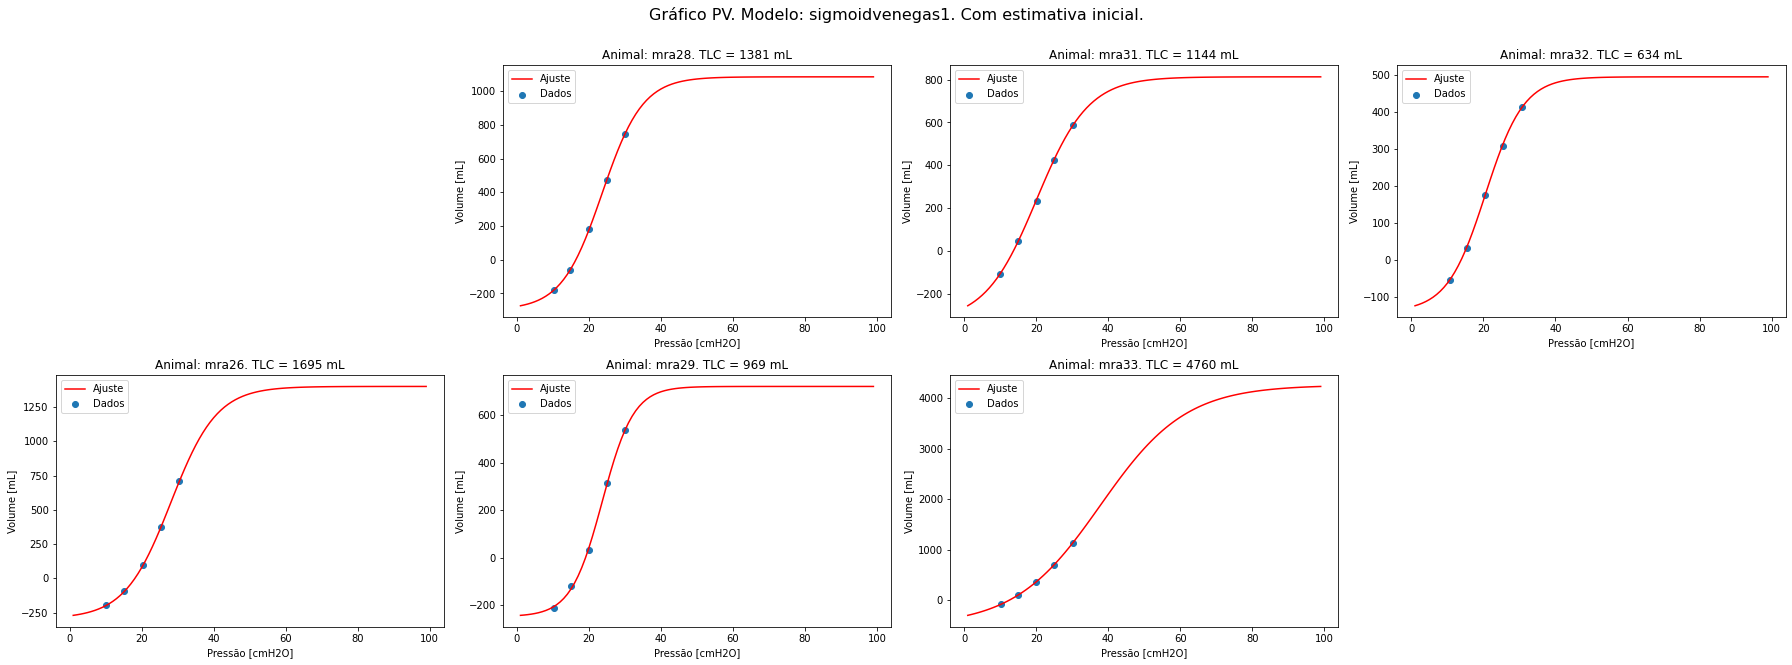

In [46]:
testa_modelo(dadosdfD5, sigmoidvenegas1, metodo = 'lm', meu_p0 = [-200, 2000, 25, 5], texto = 'Com estimativa inicial.', TLC_index=1)

### Sigmoid Paiva

Testando caso 0.
[9.49408862e+02 3.94446375e+03 3.32727268e-01]
mra34
Testando caso 1.
[7.97379851e+02 1.84952760e+04 4.11962896e-01]
mra28
Testando caso 2.
[6.03177195e+02 2.46147320e+03 3.57219260e-01]
mra31


<ipython-input-2-d1be3fbc6e7a>:11: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x)))
<ipython-input-2-d1be3fbc6e7a>:11: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x)))
<ipython-input-2-d1be3fbc6e7a>:11: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x)))


Testando caso 3.
[4.18995310e+02 2.63666591e+03 3.61332306e-01]
mra32
Testando caso 4.
[7.73354937e+02 1.44470458e+05 4.67139296e-01]
mra26


<ipython-input-2-d1be3fbc6e7a>:11: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x)))
<ipython-input-2-d1be3fbc6e7a>:11: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x)))


Testando caso 5.
[5.50848215e+02 1.89596532e+07 6.81542233e-01]
mra29
Testando caso 6.
[1.37906422e+03 6.57779524e+02 2.64728874e-01]
mra33


<ipython-input-2-d1be3fbc6e7a>:11: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x)))
<ipython-input-2-d1be3fbc6e7a>:11: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x)))


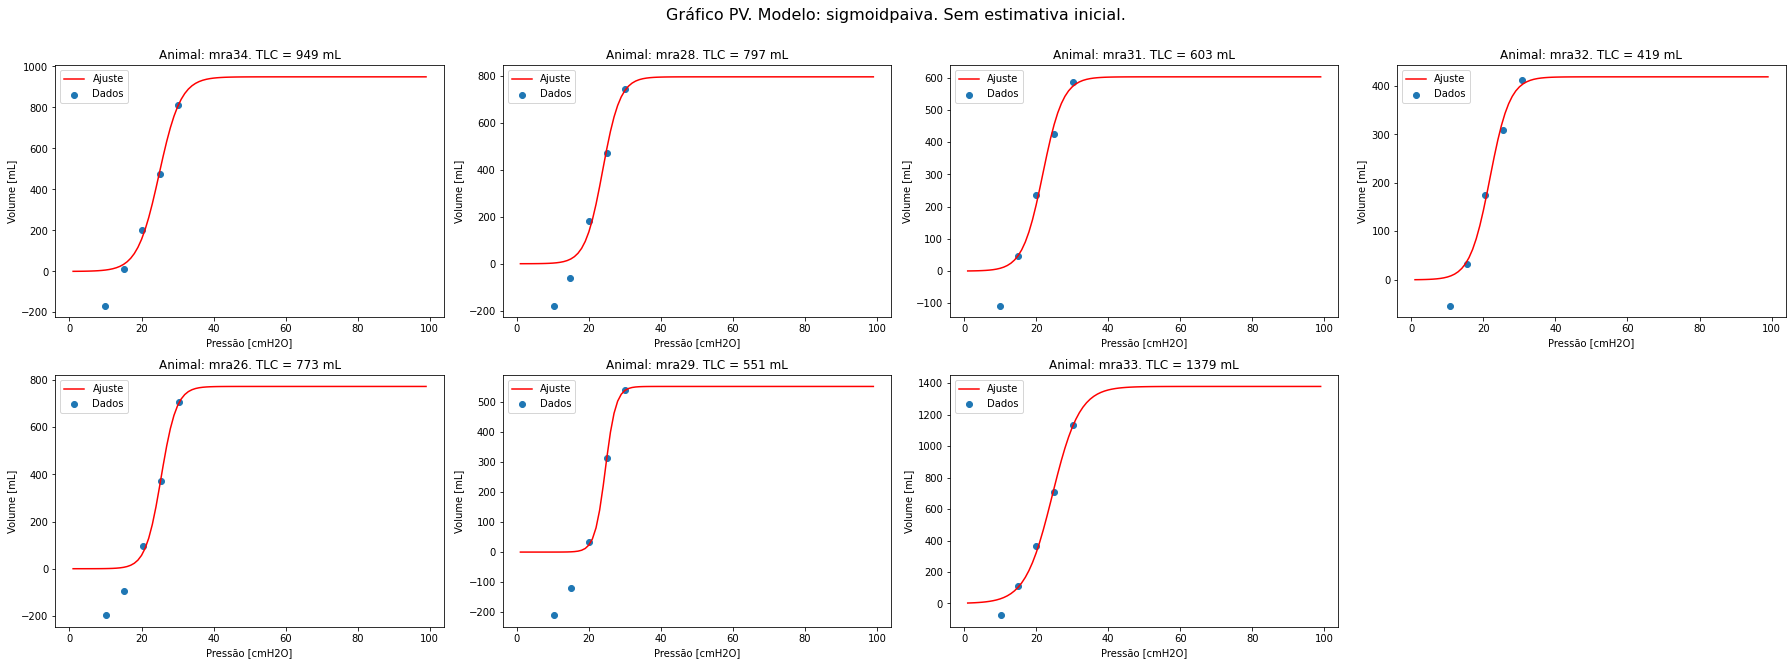

In [47]:
# sem chute inicial
testa_modelo(dadosdfD5, sigmoidpaiva, metodo = 'lm', texto = 'Sem estimativa inicial.')

Testando caso 0.
[9.49410823e+02 3.94433942e+03 3.32725789e-01]
mra34
Testando caso 1.
[7.97360985e+02 1.85105497e+04 4.11999851e-01]
mra28
Testando caso 2.
[6.03183671e+02 2.46049974e+03 3.57200243e-01]
mra31
Testando caso 3.
[4.18995418e+02 2.63663387e+03 3.61331735e-01]
mra32
Testando caso 4.
[7.73355941e+02 1.44462924e+05 4.67137114e-01]
mra26
Testando caso 5.
[5.50834973e+02 1.90421951e+07 6.81718883e-01]
mra29
Testando caso 6.
[1.37905308e+03 6.57829461e+02 2.64732799e-01]
mra33


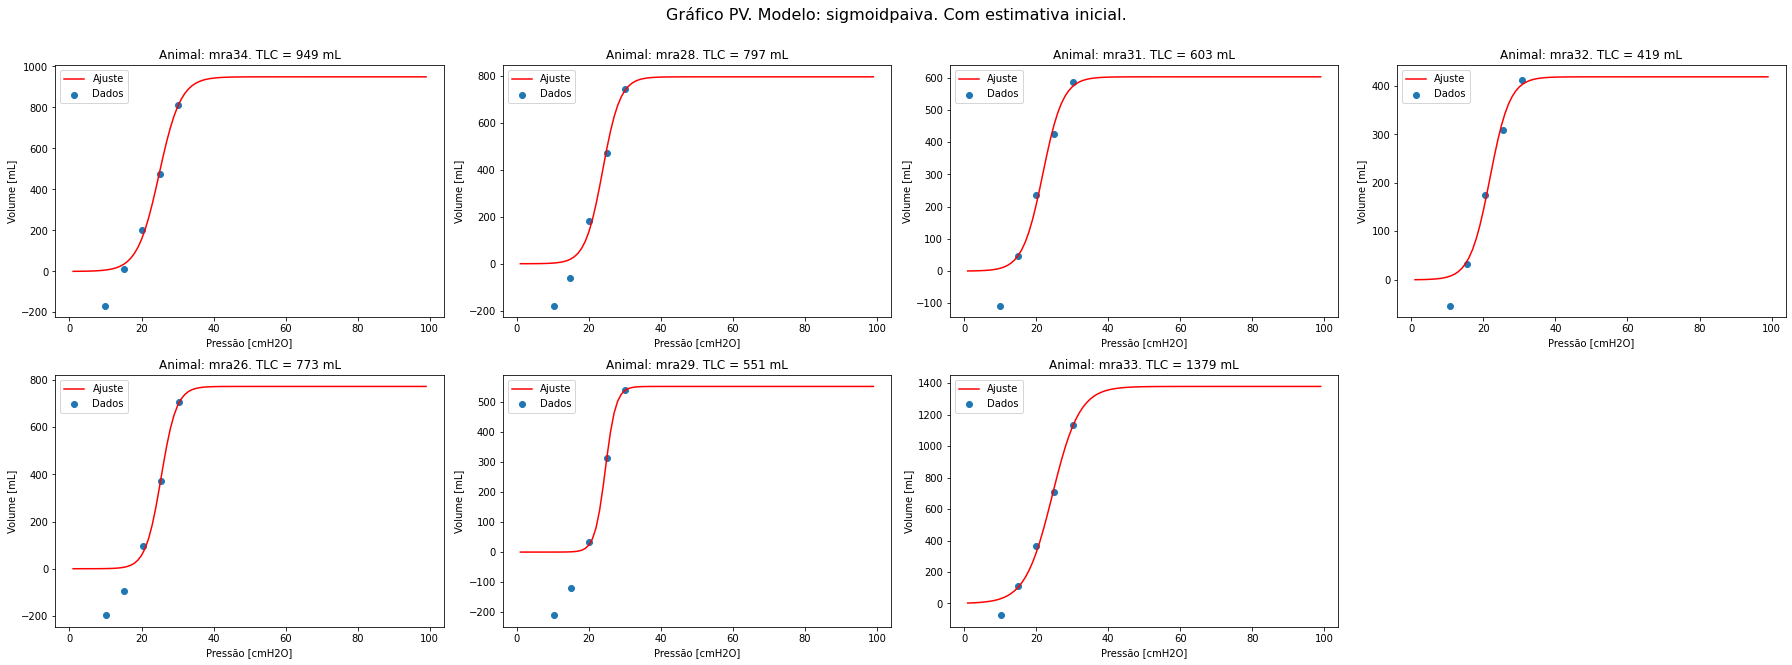

In [48]:
# com chute inicial
testa_modelo(dadosdfD5, sigmoidpaiva, metodo = 'lm', meu_p0 = [2000, 2000, 0.4], texto = 'Com estimativa inicial.')

### Sigmoid Paiva com offset, sem chute inicial

Testando caso 0.
[ 9.13639132e+01  2.17064340e+06 -2.21009057e+05  2.66995898e+02]
mra34
Testando caso 1.
[ 9.02735779e+01  3.27865824e+06 -3.16792751e+05  2.31229622e+02]
mra28
Testando caso 2.
[ 9.17220531e+01  2.11318589e+06 -2.12819861e+05  2.37417488e+02]
mra31


<ipython-input-2-d1be3fbc6e7a>:14: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x))) + offset
/home/erick2/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-d1be3fbc6e7a>:14: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x))) + offset
/home/erick2/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-d1be3fbc6e7a>:14: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x))) + offset
/home/erick2/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the paramet

Testando caso 3.
[ 9.28894468e+01  4.22146527e+06 -4.01767635e+05  1.74935728e+02]
mra32
Testando caso 4.
[ 8.23252130e+01  3.37059716e+06 -3.40323401e+05  1.76924653e+02]
mra26


<ipython-input-2-d1be3fbc6e7a>:14: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x))) + offset
/home/erick2/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-d1be3fbc6e7a>:14: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x))) + offset
/home/erick2/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Testando caso 5.
[ 7.41421942e+01  4.33386980e+06 -4.54068179e+05  1.11076908e+02]
mra29
Testando caso 6.
[ 9.90308989e+01  1.73395218e+06 -1.67800472e+05  4.46739375e+02]
mra33


<ipython-input-2-d1be3fbc6e7a>:14: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x))) + offset
/home/erick2/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2-d1be3fbc6e7a>:14: RuntimeWarning: overflow encountered in exp
  return TLC/(1+(k1*np.exp(-k2*x))) + offset
/home/erick2/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


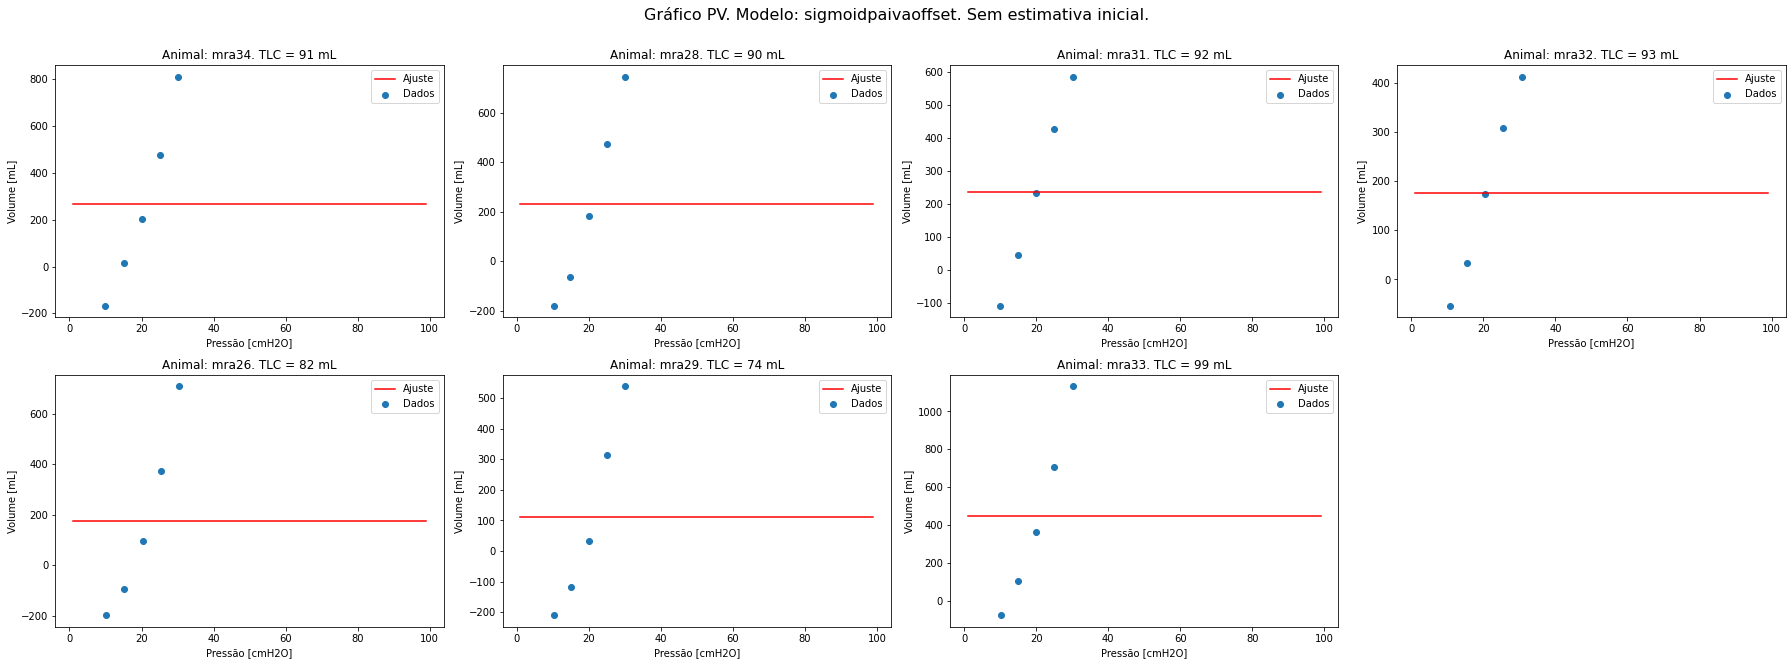

In [49]:
testa_modelo(dadosdfD5, sigmoidpaivaoffset, metodo = 'lm', texto = 'Sem estimativa inicial.')

Testando caso 0.
[ 1.76773054e+09  5.09754099e+06  4.96163900e-02 -7.30660736e+02]
mra34
Testando caso 1.
[ 1.38137407e+03  6.69611530e+01  1.77614477e-01 -2.97059944e+02]
mra28
Testando caso 2.
[ 1.14379785e+03  1.65183723e+01  1.39198179e-01 -3.30831280e+02]
mra31
Testando caso 3.
[ 6.34256660e+02  4.71748347e+01  1.87499963e-01 -1.39559254e+02]
mra32
Testando caso 4.
[ 1.69533852e+03  8.09717178e+01  1.56341926e-01 -2.94675514e+02]
mra26
Testando caso 5.
[ 9.68976216e+02  2.31899856e+02  2.29749227e-01 -2.47557373e+02]
mra29
Testando caso 6.
[ 4.76042152e+03  2.42673740e+01  8.43400808e-02 -5.00912759e+02]
mra33


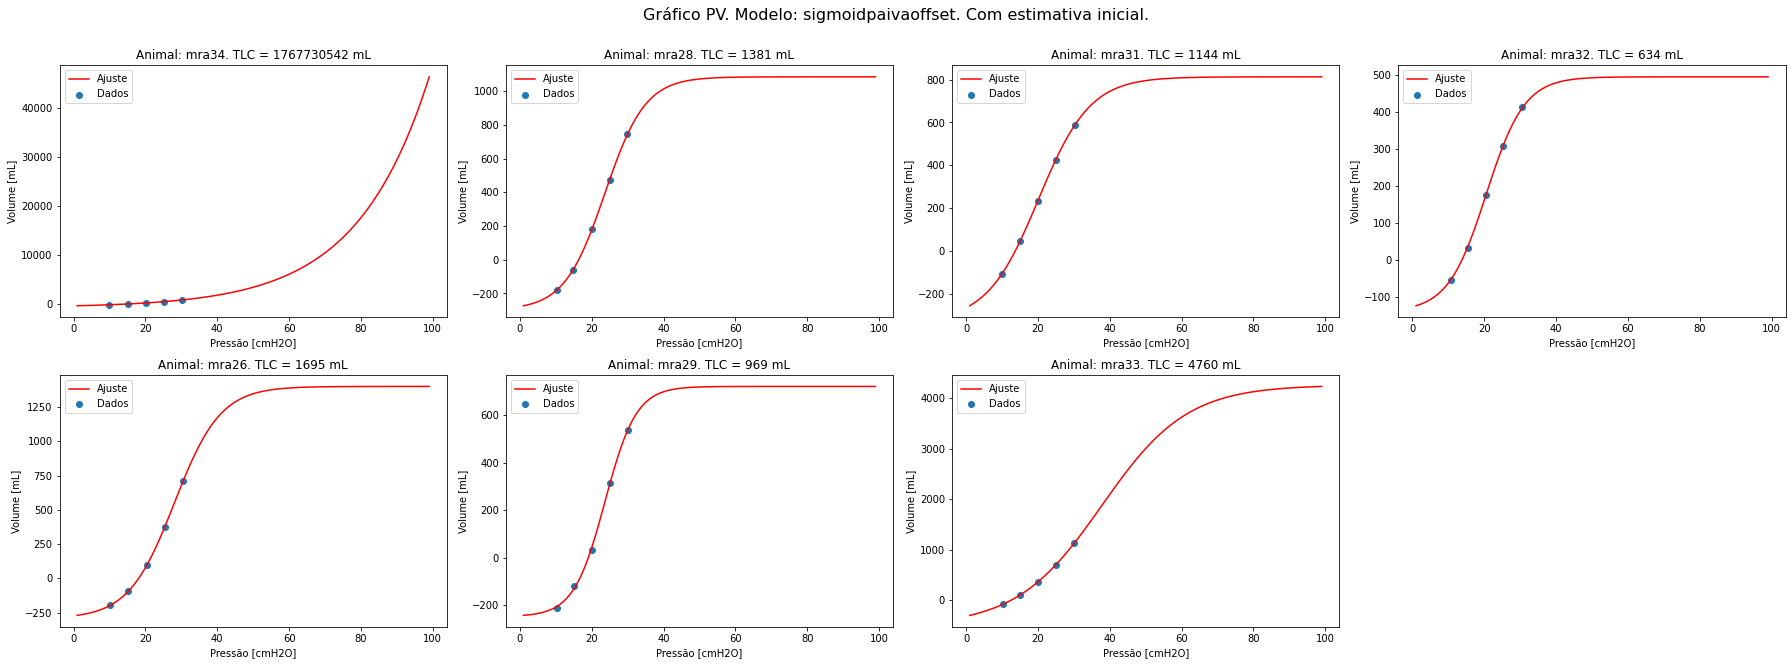

In [50]:
testa_modelo(dadosdfD5, sigmoidpaivaoffset, metodo = 'lm', meu_p0 = [2000, 2000, 0.4, -300], texto = 'Com estimativa inicial.')

In [23]:
a = 'bla'
print(f'com f: oi {a}')
print('sem f: oi {a}')

com f: oi bla
sem f: oi {a}


In [26]:
parameters = [6.34256660e+02,  4.71748347e+01,  1.87499963e-01, -1.39559254e+02]
print(f'{parameters}')

[634.25666, 47.1748347, 0.187499963, -139.559254]
